# 3. Модель сегментации текста 

In [1]:
import os
import sys
import random
import itertools
import pickle
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from pandarallel import pandarallel

import pymorphy2
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from keras.preprocessing.sequence import pad_sequences

sys.path.append("..")
from src import *

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Загрузка данных

In [2]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [3]:
lenta_train["labels_new"] = (
    lenta_train["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
train_texts = list(map(lambda x: x.split(" "), lenta_train["text_new"].to_list()))
train_labels = list(map(lambda x: x.split(" "), lenta_train["labels_new"].to_list()))

lenta_test["labels_new"] = (
    lenta_test["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
test_texts = list(map(lambda x: x.split(" "), lenta_test["text_new"].to_list()))
test_labels = list(map(lambda x: x.split(" "), lenta_test["labels_new"].to_list()))

## 2. Сборка датасета

In [4]:
PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0

PAD_LABEL = "<NOLABEL>"
PAD_LABEL_ID = 0

EMPTY_LABEL = "_"
EMPTY_LABEL_ID = 1

train_texts_global = list(itertools.chain(*train_texts))
train_labels_global = list(itertools.chain(*train_labels))
train_labels_global = list(filter(lambda x: x != EMPTY_LABEL, train_labels_global))

UNIQUE_TOKENS = [PAD_TOKEN] + list(set(train_texts_global))
UNIQUE_LABELS = [PAD_LABEL, EMPTY_LABEL] + list(set(train_labels_global))

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

label2id = {label: i for i, label in enumerate(UNIQUE_LABELS)}
id2label = {i: label for label, i in label2id.items()}

MAX_SENTENCE_LEN = lenta_train.text_new.str.split(" ").str.len().max()
train_size = len(train_texts)
test_size = len(test_texts)
TOKENS_NUM = len(UNIQUE_TOKENS)
LABELS_NUM = len(UNIQUE_LABELS)

print(MAX_SENTENCE_LEN, train_size, test_size, TOKENS_NUM, LABELS_NUM)

282 403411 100853 635711 1162


In [5]:
def get_tensor_dataset(sentences, labels, token2id, label2id, max_sent_len):
    sent_num = len(sentences)
    
    inputs = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    targets = torch.zeros((sent_num, max_sent_len), dtype=torch.long)
    
    for text_i, text in tqdm(enumerate(sentences)):
        text = text[:max_sent_len]
        for token_i, token in enumerate(text):
            label = labels[text_i][token_i]
            inputs[text_i, token_i] = token2id.get(token, 0)
            targets[text_i, token_i] = label2id.get(label, 0)
            
    return TensorDataset(inputs, targets)

# train_dataset = get_tensor_dataset(sentences=train_texts, 
#                                    labels=train_labels, 
#                                    token2id=token2id, 
#                                    label2id=label2id, 
#                                    max_sent_len=MAX_SENTENCE_LEN)

# test_dataset = get_tensor_dataset(sentences=test_texts, 
#                                    labels=test_labels, 
#                                    token2id=token2id, 
#                                    label2id=label2id, 
#                                    max_sent_len=MAX_SENTENCE_LEN)

# torch.save(train_dataset, "../data/train_dataset.tensor_dataset")
# torch.save(test_dataset, "../data/test_dataset.tensor_dataset")

train_dataset = torch.load("../data/train_dataset.tensor_dataset")
test_dataset = torch.load("../data/test_dataset.tensor_dataset")

403411it [04:07, 1630.13it/s]
100853it [04:02, 416.18it/s]


## 3. Архитектура

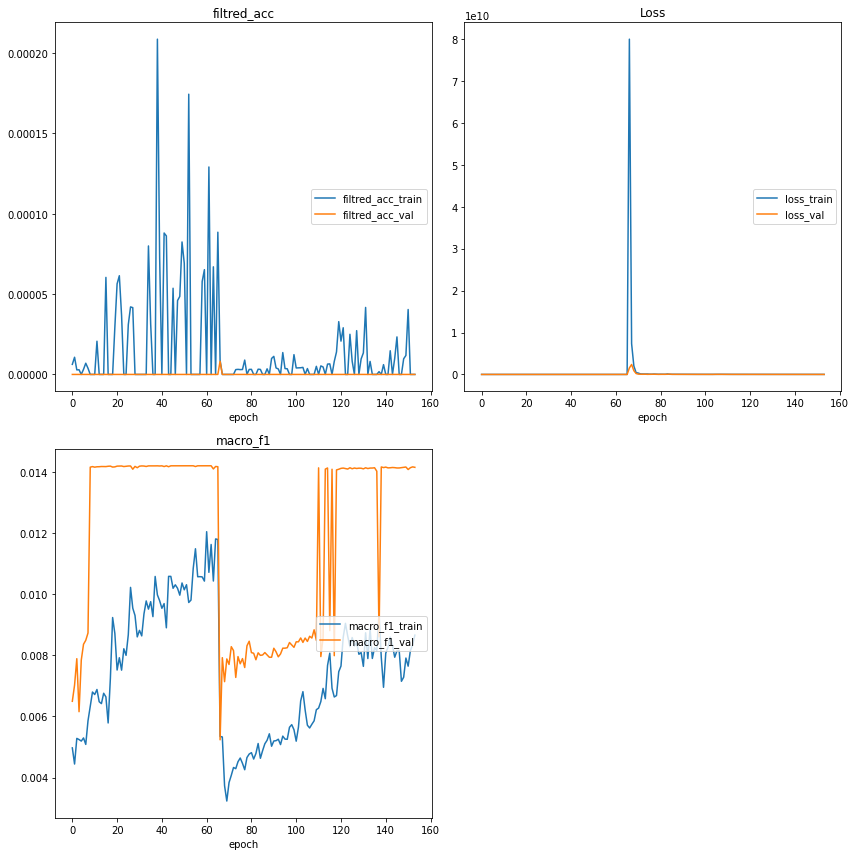

filtred_acc
	filtred_acc_train 	 (min:    0.000, max:    0.000, cur:    0.000)
	filtred_acc_val  	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss_train       	 (min:   34.521, max: 79953765775.256, cur: 4545620.938)
	loss_val         	 (min:   17.566, max: 2372051744.000, cur: 3953331.562)
macro_f1
	macro_f1_train   	 (min:    0.003, max:    0.012, cur:    0.009)
	macro_f1_val     	 (min:    0.005, max:    0.014, cur:    0.014)
Модель не улучшилась за последние 100 эпох, прекращаем обучение


In [106]:
BATCH_SIZE = 256
EPOCH = 10

embedding_size = 128
num_layers = 5
kernel_size = 5
dropout = 0.2

for embedding_size in [4, 16, 32, 64, 128]:
    for kernel_size in [3, 5, 7]:
        model = NnClassifier(
            tokens_num=TOKENS_NUM, 
            labels_num=LABELS_NUM, 
            embedding_size=embedding_size, 
            backbone=ConvResNet,
            input_size=embedding_size,
            num_layers=num_layers,
            kernel_size=kernel_size,
            dropout=dropout,
        )
        params = get_model_params_num(model)

        model_name = create_model_name(
            model="ConvResNet", 
            embedding_size=embedding_size, 
            num_layers=num_layers,
            kernel_size=kernel_size,
            dropout=dropout,
            params=params
        )
        print(model_name)

        learner = TorchLearner(
            model=model, 
            loss_function=F.cross_entropy, 
            train_dataset=train_dataset, 
            val_dataset=test_dataset, 
            metrics={"macro_f1": get_f1_score, "filtred_acc": get_filtred_accuracy_score}, 
            optimizer=optim.Adam, 
            batch_size=BATCH_SIZE, 
            device="cuda",
            lr=1e-1
        )

        learner.fit(
            epoch=EPOCH * 100, 
            step_per_epoch_train=train_size // BATCH_SIZE // 100, 
            step_per_epoch_val=test_size // BATCH_SIZE // 100, 
            early_stopping_patience=EPOCH * 100 // 10
        )

        torch.save(learner.best_model.state_dict(), 
                   os.path.join("../models/nn_models", model_name + ".model"))

        with open(os.path.join("../logs/nn_models", model_name + ".log"), "w") as f:
            json.dump(learner.history, f)

In [150]:
model_name

'model_ConvResNet_embedding_size_4_num_layers_5_kernel_size_7_dropout_0.2_params_2549234.log'

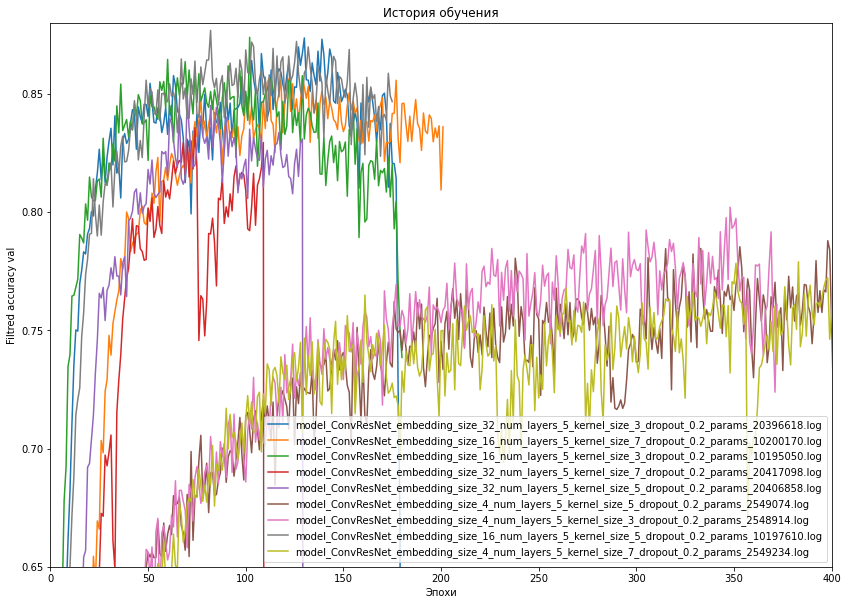

In [2]:
plt.figure(figsize=(14, 10))
for model_name in os.listdir("../logs/nn_models"):
    with open(os.path.join("../logs/nn_models", model_name)) as f:
        history = json.load(f)
    emb_size = model_name.replace(".model", "").split("_")[4]
    if int(emb_size) < 64:
        plt.plot(history["epoch"], history["filtred_acc_val"], label=model_name)
plt.xlim(0, 400)
plt.ylim(0.65, 0.88)
plt.title("История обучения")
plt.xlabel("Эпохи")
plt.ylabel("Filtred accuracy val")
plt.legend()

In [3]:
for model_name in sorted(os.listdir("../logs/nn_models")):
    with open(os.path.join("../logs/nn_models", model_name)) as f:
        history = json.load(f)
    emb_size = model_name.replace(".model", "").split("_")[4]
    if int(emb_size) < 64:
        print(model_name)
        print(round(max(history["filtred_acc_val"]), 2), round(max(history["macro_f1_val"]), 2))
        print()

model_ConvResNet_embedding_size_16_num_layers_5_kernel_size_3_dropout_0.2_params_10195050.log
0.87 0.71

model_ConvResNet_embedding_size_16_num_layers_5_kernel_size_5_dropout_0.2_params_10197610.log
0.88 0.7

model_ConvResNet_embedding_size_16_num_layers_5_kernel_size_7_dropout_0.2_params_10200170.log
0.86 0.68

model_ConvResNet_embedding_size_32_num_layers_5_kernel_size_3_dropout_0.2_params_20396618.log
0.87 0.71

model_ConvResNet_embedding_size_32_num_layers_5_kernel_size_5_dropout_0.2_params_20406858.log
0.85 0.67

model_ConvResNet_embedding_size_32_num_layers_5_kernel_size_7_dropout_0.2_params_20417098.log
0.84 0.65

model_ConvResNet_embedding_size_4_num_layers_5_kernel_size_3_dropout_0.2_params_2548914.log
0.8 0.53

model_ConvResNet_embedding_size_4_num_layers_5_kernel_size_5_dropout_0.2_params_2549074.log
0.79 0.51

model_ConvResNet_embedding_size_4_num_layers_5_kernel_size_7_dropout_0.2_params_2549234.log
0.8 0.54



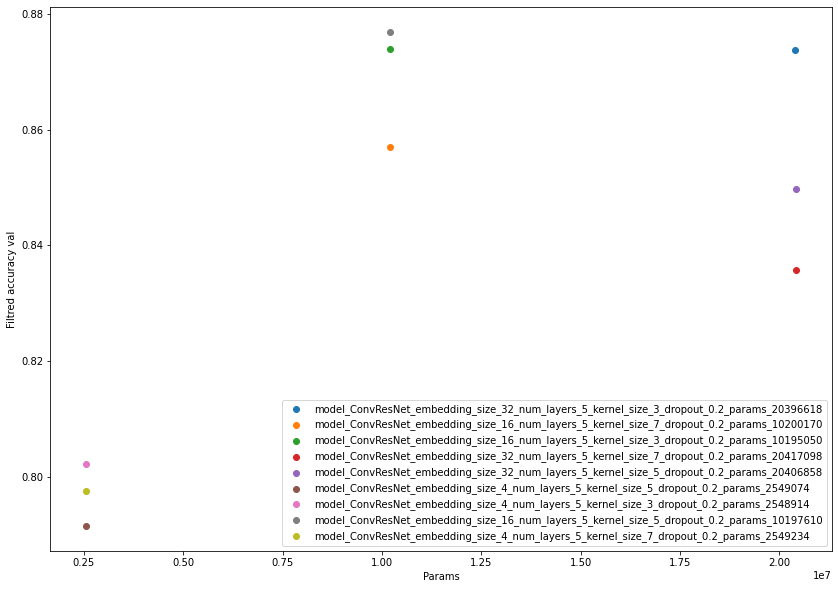

In [14]:
plt.figure(figsize=(14, 10))
for model_name in os.listdir("../logs/nn_models"):
    with open(os.path.join("../logs/nn_models", model_name)) as f:
        history = json.load(f)
    params = model_name.replace(".log", "").split("_")[-1]
    kernel = model_name.replace(".log", "").split("_")[-5]
    emb_size = model_name.replace(".log", "").split("_")[4]
    if int(emb_size) < 64:
        plt.scatter(int(params), max(history["filtred_acc_val"]), label=model_name.replace(".log", ""))
plt.xlabel("Params")
plt.ylabel("Filtred accuracy val")
plt.legend()

In [27]:
data = []
for model_name in os.listdir("../logs/nn_models"):
    with open(os.path.join("../logs/nn_models", model_name)) as f:
        history = json.load(f)
    params = model_name.replace(".log", "").split("_")[-1]
    kernel = model_name.replace(".log", "").split("_")[-5]
    emb_size = model_name.replace(".log", "").split("_")[4]
    x[kernel].append(int(params))
    y[kernel].append(max(history["filtred_acc_val"]))
    data.append((int(emb_size), int(kernel), int(params), max(history["filtred_acc_val"]), max(history["macro_f1_val"])))

In [63]:
data_df = (
    pd.DataFrame(data, columns=["emb_size", "kernel", "params", "filtred_acc_val", "macro_f1_val"])
        .sort_values("filtred_acc_val")
)
data_df = data_df[data_df.emb_size < 64]

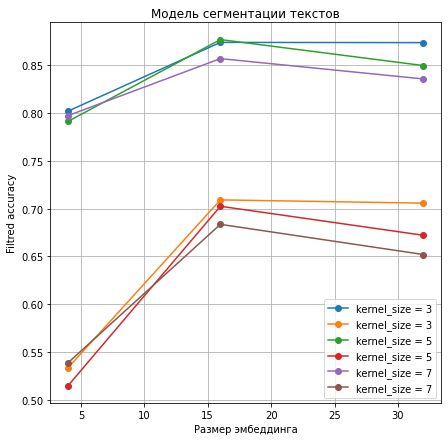

In [67]:
plt.figure(figsize=(7, 7))
for kernel in sorted(data_df.kernel.unique()):
    curr = data_df[data_df.kernel == kernel].sort_values("emb_size")
    plt.plot(curr.emb_size, curr.filtred_acc_val, "-o", label="kernel_size = "+str(kernel))
    plt.plot(curr.emb_size, curr.macro_f1_val, "-o", label="kernel_size = "+str(kernel))
plt.legend()
plt.title("Модель сегментации текстов")
plt.xlabel("Размер эмбеддинга")
plt.ylabel("Filtred accuracy")
plt.grid()
plt.legend()

In [37]:
curr

,emb_size,kernel,params,filtred_acc_val,macro_f1_val
9,4,3,2548914,0.802135,0.533621
0,32,3,20396618,0.873782,0.705732
4,16,3,10195050,0.874022,0.709158


In [25]:
y

defaultdict(list,
            {'3': [0.8737822522725017,
              0.4901838703060366,
              0.8740223383883956,
              0.007877317944111607,
              0.8021352692366597],
             '7': [0.0,
              0.8570376806095386,
              0.8357574880764818,
              8.185985592665357e-06,
              0.7974516502704476],
             '5': [0.8497663985113215,
              0.7914284856580946,
              0.009713818487506918,
              0.8769627188557373,
              0.0]})